## Montgomery County Crash Data

## Loading Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
from statsmodels.graphics.mosaicplot import mosaic


import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic

import geoplot.crs as gcrs
import geoplot as gplt

import requests
import json
from scipy.stats import chi2_contingency
import folium

from pingouin import ancova

import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
##loading cleaned crash data provided by the client
df = pd.read_excel("Crashes_locations_cleaned.xlsx") 

##loading additional data sets that might be useful for addressing the client's challenge
hundredth= pd.read_csv("MDOT_SHA_Mile_Points_(100th).csv", low_memory=False) #loading  milepoint data downloaded from state's website
boundaries= requests.get('https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDOT_SHA_County_Boundaries/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json').json()


pd.set_option('display.max_columns', None) 

## Wrangling Crash Data

In [3]:
# Checking out the shape of the crash data
print(df.shape)

# Checking out the top five columns of the crash data
df.head() 

(95716, 65)


,ReportNumber,LocalCaseNumber,ACRSReportType,AgencyName,AtFault,CollisionType,CrashDateTime,NON_MOTORIST_INVOLVED,NON_MOTORIST_INVOLVED_KSI,CRASH_HIGHEST_INJURY,KSI,FATAL_CRASH,BIKE_INVOLVED,BIKE_INVOLVED_KSI,BIKE_HIGHEST_INJURY,PED_INVOLVED,PED_INVOLVED_KSI,PED_HIGHEST_INJURY,MOTORIST_HIGHEST_INJURY,DRIVER_HIGHEST_INJURY,PASSENGER_HIGHEST_INJURY,LaneDirection,FixedObjectStruck,HitAndRun,HarmfulEvent1,HarmfulEvent2,ReportCountyLocation,NonTraffic,OffRoadDescription,IntegerchangeArea,InterchangeIdentification,IntersectionType,Junction,LaneNumber,POL_LAT,POL_LON,FINAL_LAT,FINAL_LON,LaneType,Light,MilePointDirection,MilePointDistance,MilePointDistUnits,NumberOfLanes,LOGMILE_DIR,MILEPOINT,MUNICIPAL,MUNICIPAL_AREA_CODE,REFERENCE_MUNI,ROUTE_TYPE,ROUTE_SUFFIX,ROUTE_NUMBER,ROAD_NAME,REFERENCE_ROUTE_TYPE,REFERENCE_ROUTE_SUFFIX,REFERENCE_ROUTE_NUMBER,REFERENCE_ROADNAME,RoadAlignment,RoadCondition,RoadDivision,RoadGrade,Ramp,SurfaceCondition,TrafficControl,Weather
0,MCP11520005,15000008,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 00:30:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,Y,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION RELATED,NaN,FOUR-WAY INTERSECTION,INTERSECTION RELATED,1.0,39.022001,-77.102673,39.022465,-77.102737,NaN,DARK LIGHTS ON,N,0.0,FEET,3.0,N,4.38,NaN,NaN,NaN,MD,NaN,355.0,ROCKVILLE PIKE,CO,NaN,326.0,GROSVENOR LA,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR
1,MCP2686000D,15000017,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 01:10:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,S,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,ON RAMP EXIT AREA,NaN,T-INTERSECTION,INTERCHANGE RELATED,NaN,39.196610,-77.265547,39.196526,-77.265297,ON RAMP,DARK LIGHTS ON,S,10.0,FEET,1.0,S,0.15,NaN,NaN,NaN,RP,NaN,270.0,RAMP 5 FR RAMP 8 TO FATHER HURLEY BLVD,CO,NaN,4556.0,FATHER HURLEY BLVD,CURVE LEFT,NO DEFECTS,ONE-WAY TRAFFICWAY,HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,NaN
2,MCP2783000G,15000025,Injury Crash,Montgomery County Police,DRIVER,HEAD ON,2015-01-01 01:14:00,MOTORIST,MOTORIST,3,False,False,False,False,0,False,False,0,3,3,0,E,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,NaN,NaN,FOUR-WAY INTERSECTION,INTERSECTION,2.0,39.096217,-77.109803,39.096077,-77.109871,NaN,DARK LIGHTS ON,E,0.0,FEET,3.0,E,25.21,NaN,NaN,NaN,MD,NaN,28.0,NORBECK RD,CO,NaN,3377.0,BAUER DR,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR
3,MCP2674000D,15000016,Property Damage Crash,Montgomery County Police,DRIVER,OPPOSITE DIR BOTH LEFT TURN,2015-01-01 01:26:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,W,NaN,N,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION,NaN,FOUR-WAY INTERSECTION,INTERSECTION,NaN,39.158059,-77.204349,39.158020,-77.204430,LEFT TURN LANE,DARK LIGHTS ON,N,0.0,FEET,2.0,N,0.76,NaN,NaN,NaN,CO,NaN,4863.0,CHRISTOPHER AVE,MD,NaN,124.0,MONTGOMERY VILLAGE AVE,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,CLEAR
4,MCP23000002,15000197,Property Damage Crash,Montgomery County Police,UNKNOWN,SINGLE VEHICLE,2015-01-01 02:00:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,N,OTHER,NaN,Montgomery,NO,NaN,NaN,NaN,NaN,NON INTERSECTION,1.0,39.148678,-77.093848,39.148697,-77.093819,NaN,DARK NO LIGHTS,N,10.0,FEET,1.0,N,1.81,NaN,NaN,NaN,CO,NaN,136.0,CASHELL RD,CO,NaN,4201.0,BETTSWOOD DR,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",LEVEL,NaN,DRY,NaN,CLEAR


In [4]:
# Getting more information about the crash data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95716 entries, 0 to 95715
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ReportNumber               95716 non-null  object        
 1   LocalCaseNumber            95716 non-null  object        
 2   ACRSReportType             95716 non-null  object        
 3   AgencyName                 95716 non-null  object        
 4   AtFault                    95716 non-null  object        
 5   CollisionType              95218 non-null  object        
 6   CrashDateTime              95716 non-null  datetime64[ns]
 7   NON_MOTORIST_INVOLVED      95716 non-null  object        
 8   NON_MOTORIST_INVOLVED_KSI  95716 non-null  object        
 9   CRASH_HIGHEST_INJURY       95716 non-null  int64         
 10  KSI                        95716 non-null  bool          
 11  FATAL_CRASH                95716 non-null  bool          
 12  BIKE

In [5]:
# Getting the value count for agency names
df['AgencyName'].value_counts()

AgencyName
Montgomery County Police     76612
MONTGOMERY                    5816
Rockville Police Departme     5575
Gaithersburg Police Depar     4432
Takoma Park Police Depart     1775
Maryland-National Capital      782
ROCKVILLE                      350
GAITHERSBURG                   229
TAKOMA                          95
MCPARK                          50
Name: count, dtype: int64

In [6]:
# Extracting the reporting jurisdiction from the reporting number
df['Agency'] = df['ReportNumber'].str.extract('([A-Za-z]+)')

#Getting value counts for agency
df['Agency'].value_counts()

Agency
MCP    82428
DD      5925
EJ      4661
DM      1870
HA       832
Name: count, dtype: int64

In [7]:
#Providing full names for the extracted reporting jurisdiction
# Defining data dictionary containing with agency names
new_agency_name= {'MCP':'Montgomery County Police',
                 'DD':'Rockville Police',
                 'EJ':'Gaithersburg Police',
                 'DM':'Takoma Park Police',
                 'HA':'Maryland-National Capital'} 

# replacing the values in the column 
df['agency_clean']=df['Agency'].replace(new_agency_name).astype('category')

# Getting count for the newly created column
df['agency_clean'].value_counts()


agency_clean
Montgomery County Police     82428
Rockville Police              5925
Gaithersburg Police           4661
Takoma Park Police            1870
Maryland-National Capital      832
Name: count, dtype: int64

In [8]:
# Extracting year, month, day, date, and time from CrashDateTime
df['Year'] = df['CrashDateTime'].dt.year
df['Month']=df['CrashDateTime'].dt.month
df['Day']=df['CrashDateTime'].dt.day

In [9]:
df.head()

,ReportNumber,LocalCaseNumber,ACRSReportType,AgencyName,AtFault,CollisionType,CrashDateTime,NON_MOTORIST_INVOLVED,NON_MOTORIST_INVOLVED_KSI,CRASH_HIGHEST_INJURY,KSI,FATAL_CRASH,BIKE_INVOLVED,BIKE_INVOLVED_KSI,BIKE_HIGHEST_INJURY,PED_INVOLVED,PED_INVOLVED_KSI,PED_HIGHEST_INJURY,MOTORIST_HIGHEST_INJURY,DRIVER_HIGHEST_INJURY,PASSENGER_HIGHEST_INJURY,LaneDirection,FixedObjectStruck,HitAndRun,HarmfulEvent1,HarmfulEvent2,ReportCountyLocation,NonTraffic,OffRoadDescription,IntegerchangeArea,InterchangeIdentification,IntersectionType,Junction,LaneNumber,POL_LAT,POL_LON,FINAL_LAT,FINAL_LON,LaneType,Light,MilePointDirection,MilePointDistance,MilePointDistUnits,NumberOfLanes,LOGMILE_DIR,MILEPOINT,MUNICIPAL,MUNICIPAL_AREA_CODE,REFERENCE_MUNI,ROUTE_TYPE,ROUTE_SUFFIX,ROUTE_NUMBER,ROAD_NAME,REFERENCE_ROUTE_TYPE,REFERENCE_ROUTE_SUFFIX,REFERENCE_ROUTE_NUMBER,REFERENCE_ROADNAME,RoadAlignment,RoadCondition,RoadDivision,RoadGrade,Ramp,SurfaceCondition,TrafficControl,Weather,Agency,agency_clean,Year,Month,Day
0,MCP11520005,15000008,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 00:30:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,Y,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION RELATED,NaN,FOUR-WAY INTERSECTION,INTERSECTION RELATED,1.0,39.022001,-77.102673,39.022465,-77.102737,NaN,DARK LIGHTS ON,N,0.0,FEET,3.0,N,4.38,NaN,NaN,NaN,MD,NaN,355.0,ROCKVILLE PIKE,CO,NaN,326.0,GROSVENOR LA,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1
1,MCP2686000D,15000017,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 01:10:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,S,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,ON RAMP EXIT AREA,NaN,T-INTERSECTION,INTERCHANGE RELATED,NaN,39.196610,-77.265547,39.196526,-77.265297,ON RAMP,DARK LIGHTS ON,S,10.0,FEET,1.0,S,0.15,NaN,NaN,NaN,RP,NaN,270.0,RAMP 5 FR RAMP 8 TO FATHER HURLEY BLVD,CO,NaN,4556.0,FATHER HURLEY BLVD,CURVE LEFT,NO DEFECTS,ONE-WAY TRAFFICWAY,HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,NaN,MCP,Montgomery County Police,2015,1,1
2,MCP2783000G,15000025,Injury Crash,Montgomery County Police,DRIVER,HEAD ON,2015-01-01 01:14:00,MOTORIST,MOTORIST,3,False,False,False,False,0,False,False,0,3,3,0,E,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,NaN,NaN,FOUR-WAY INTERSECTION,INTERSECTION,2.0,39.096217,-77.109803,39.096077,-77.109871,NaN,DARK LIGHTS ON,E,0.0,FEET,3.0,E,25.21,NaN,NaN,NaN,MD,NaN,28.0,NORBECK RD,CO,NaN,3377.0,BAUER DR,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1
3,MCP2674000D,15000016,Property Damage Crash,Montgomery County Police,DRIVER,OPPOSITE DIR BOTH LEFT TURN,2015-01-01 01:26:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,W,NaN,N,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION,NaN,FOUR-WAY INTERSECTION,INTERSECTION,NaN,39.158059,-77.204349,39.158020,-77.204430,LEFT TURN LANE,DARK LIGHTS ON,N,0.0,FEET,2.0,N,0.76,NaN,NaN,NaN,CO,NaN,4863.0,CHRISTOPHER AVE,MD,NaN,124.0,MONTGOMERY VILLAGE AVE,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1
4,MCP23000002,15000197,Property Damage Crash,Montgomery County Police,UNKNOWN,SINGLE VEHICLE,2015-01-01 02:00:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,N,OTHER,NaN,Montgomery,NO,NaN,NaN,NaN,NaN,NON INTERSECTION,1.0,39.148678,-77.093848,39.148697,-77.093819,NaN,DARK NO LIGHTS,N,10.0,FEET,1.0,N,1.81,NaN,NaN,NaN,CO,NaN,136.0,CASHELL RD,CO,NaN,4201.0,BETTSWOOD DR,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",LEVEL,NaN,DRY,NaN,CLEAR,MCP,Montgomery County Police,2015,1,1


In [10]:
# Getting value counts for the nontraffic column
df['NonTraffic'].value_counts()

NonTraffic
NO     83399
YES    12317
Name: count, dtype: int64

In [11]:
# Selecting only traffic accidents
df= df[df.NonTraffic == 'NO']

In [12]:
# Getting value counts for the milepointsdisunit
df['MilePointDistUnits'].value_counts()

MilePointDistUnits
FEET       77733
MILES       5241
UNKNOWN      425
Name: count, dtype: int64

In [13]:
# Converting MilePointDistUnits to feet

def feet_conv(row):
    if row['MilePointDistUnits'] == 'MILES':
        return row['MilePointDistance'] * 5280
    else:
        return row['MilePointDistance']

df['milepointdistanceinfeet'] = df.apply(feet_conv, axis=1)

In [14]:
df.head()

,ReportNumber,LocalCaseNumber,ACRSReportType,AgencyName,AtFault,CollisionType,CrashDateTime,NON_MOTORIST_INVOLVED,NON_MOTORIST_INVOLVED_KSI,CRASH_HIGHEST_INJURY,KSI,FATAL_CRASH,BIKE_INVOLVED,BIKE_INVOLVED_KSI,BIKE_HIGHEST_INJURY,PED_INVOLVED,PED_INVOLVED_KSI,PED_HIGHEST_INJURY,MOTORIST_HIGHEST_INJURY,DRIVER_HIGHEST_INJURY,PASSENGER_HIGHEST_INJURY,LaneDirection,FixedObjectStruck,HitAndRun,HarmfulEvent1,HarmfulEvent2,ReportCountyLocation,NonTraffic,OffRoadDescription,IntegerchangeArea,InterchangeIdentification,IntersectionType,Junction,LaneNumber,POL_LAT,POL_LON,FINAL_LAT,FINAL_LON,LaneType,Light,MilePointDirection,MilePointDistance,MilePointDistUnits,NumberOfLanes,LOGMILE_DIR,MILEPOINT,MUNICIPAL,MUNICIPAL_AREA_CODE,REFERENCE_MUNI,ROUTE_TYPE,ROUTE_SUFFIX,ROUTE_NUMBER,ROAD_NAME,REFERENCE_ROUTE_TYPE,REFERENCE_ROUTE_SUFFIX,REFERENCE_ROUTE_NUMBER,REFERENCE_ROADNAME,RoadAlignment,RoadCondition,RoadDivision,RoadGrade,Ramp,SurfaceCondition,TrafficControl,Weather,Agency,agency_clean,Year,Month,Day,milepointdistanceinfeet
0,MCP11520005,15000008,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 00:30:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,Y,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION RELATED,NaN,FOUR-WAY INTERSECTION,INTERSECTION RELATED,1.0,39.022001,-77.102673,39.022465,-77.102737,NaN,DARK LIGHTS ON,N,0.0,FEET,3.0,N,4.38,NaN,NaN,NaN,MD,NaN,355.0,ROCKVILLE PIKE,CO,NaN,326.0,GROSVENOR LA,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0
1,MCP2686000D,15000017,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 01:10:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,S,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,ON RAMP EXIT AREA,NaN,T-INTERSECTION,INTERCHANGE RELATED,NaN,39.196610,-77.265547,39.196526,-77.265297,ON RAMP,DARK LIGHTS ON,S,10.0,FEET,1.0,S,0.15,NaN,NaN,NaN,RP,NaN,270.0,RAMP 5 FR RAMP 8 TO FATHER HURLEY BLVD,CO,NaN,4556.0,FATHER HURLEY BLVD,CURVE LEFT,NO DEFECTS,ONE-WAY TRAFFICWAY,HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,NaN,MCP,Montgomery County Police,2015,1,1,10.0
2,MCP2783000G,15000025,Injury Crash,Montgomery County Police,DRIVER,HEAD ON,2015-01-01 01:14:00,MOTORIST,MOTORIST,3,False,False,False,False,0,False,False,0,3,3,0,E,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,NaN,NaN,FOUR-WAY INTERSECTION,INTERSECTION,2.0,39.096217,-77.109803,39.096077,-77.109871,NaN,DARK LIGHTS ON,E,0.0,FEET,3.0,E,25.21,NaN,NaN,NaN,MD,NaN,28.0,NORBECK RD,CO,NaN,3377.0,BAUER DR,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0
3,MCP2674000D,15000016,Property Damage Crash,Montgomery County Police,DRIVER,OPPOSITE DIR BOTH LEFT TURN,2015-01-01 01:26:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,W,NaN,N,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION,NaN,FOUR-WAY INTERSECTION,INTERSECTION,NaN,39.158059,-77.204349,39.158020,-77.204430,LEFT TURN LANE,DARK LIGHTS ON,N,0.0,FEET,2.0,N,0.76,NaN,NaN,NaN,CO,NaN,4863.0,CHRISTOPHER AVE,MD,NaN,124.0,MONTGOMERY VILLAGE AVE,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0
4,MCP23000002,15000197,Property Damage Crash,Montgomery County Police,UNKNOWN,SINGLE VEHICLE,2015-01-01 02:00:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,N,OTHER,NaN,Montgomery,NO,NaN,NaN,NaN,NaN,NON INTERSECTION,1.0,39.148678,-77.093848,39.148697,-77.093819,NaN,DARK NO LIGHTS,N,10.0,FEET,1.0,N,1.81,NaN,NaN,NaN,CO,NaN,136.0,CASHELL RD,CO,NaN,4201.0,BETTSWOOD DR,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",LEVEL,NaN,DRY,NaN,CLEAR,MCP,Montgomery County Police,2015,1,1,10.0


In [15]:
# Calculating the distance between the police coordinates and the final coordinates
# Defining a function 
def dist(row):
    coord1 = (row['POL_LAT'], row['POL_LON'])
    coord2 = (row['FINAL_LAT'], row['FINAL_LON'])
    if pd.isna(row['FINAL_LAT'])&pd.isna(row['FINAL_LON']):
        return "NaN"
    else:
        return geodesic(coord1, coord2).ft
df['polcoorddist'] = df.apply(dist, axis=1).astype(float)

In [16]:
# Creating a flag for coordinates that are more than 1000 feet apart

def coord_flag(row):
    if row['polcoorddist'] <=1000:
        return 'Correct'
    elif row['polcoorddist'] > 1000:
        return 'Incorrect'
    else:
        pass
df['polfinalflag'] = df.apply(coord_flag, axis=1)

In [17]:
#cleaning street abbreviations
replacement = {r'(?:^|\W)AVENUE(?:$|\W\Z)':' AVE ', 
            r'(?:^|\W)STREET(?:$|\W\Z)':' ST ', 
            r'(?:^|\W)CT.(?:$|\W\Z)':' CT ',
               r'(?:^|\W)COURT(?:$|\W\Z)':'CT ',
               r'(?:^|\W)CIRCLE(?:$|\W\Z)':' CIR ',
               r'(?:^|\W)ROAD(?:$|\W\Z)':' RD ',
               r'(?:^|\W)DRIVE(?:$|\W\Z)': ' DR ',
              r'(?:^|\W)DR.(?:$|\W\Z)': ' DR ',
               r'(?:^|\W)PLACE(?:$|\W\Z)':' PL ',
               r'(?:^|\W)PL.(?:$|\W\Z)':' PL ',
               r'(?:^|\W)AVE.(?:$|\W\Z)':' AVE ',
               r'(?:^|\W)AV(?:$|\W\Z)':' AVE ',
               r'(?:^|\W)LANE(?:$|\W\Z)':' LA ',
               r'(?:^|\W)BOULEVARD(?:$|\W\Z)':' BLVD ',
               r'(?:^|\W)ST.(?:$|\W\Z)':' ST ',
              r'(?:^|\W)BLV(?:$|\W\Z)':' BLVD ',
               r'(?:^|\W)BLVD.(?:$|\W\Z)':' BLVD ',
               r'(?:^|\W)TERRACE(?:$|\W\Z)':' TERR ',
               r'(?:^|\W)TER(?:$|\W\Z)':' TERR ',
              r'(?:^|\W)PARKWY(?:$|\W\Z)':' PKWY ',
              r'(?:^|\W)PARKWAY(?:$|\W\Z)':' PKWY ',
               r'(?:^|\W)PWK(?:$|\W\Z)':' PKWY ',
               r'(?:^|\W)PWKY(?:$|\W\Z)':' PKWY '}

df['ROAD_NAME_CLEAN']=df['ROAD_NAME'].replace(replacement, regex=True)

In [18]:
# Checking value count for light

df['Light'].value_counts()

Light
DAYLIGHT                    53654
DARK LIGHTS ON              20918
DARK NO LIGHTS               3127
DUSK                         1886
DAWN                         1803
DARK -- UNKNOWN LIGHTING      913
UNKNOWN                       328
OTHER                         127
Name: count, dtype: int64

In [19]:
# Creating new light categories
# Defining data dictionary containing new light categories
new_light= {'DARK LIGHTS ON':'Dark',
                 'DARK NO LIGHTS':'Dark',
                 'DARK -- UNKNOWN LIGHTING':'Dark',
                 'DUSK':'Twilight',
                 'DAWN':'Twilight',
                 'UNKNOWN':'Other/Unknown',
                 'OTHER': 'Other/Unknown'} 

# replacing the values in the column 
df['new_light']=df['Light'].replace(new_light).astype('category')

# Getting count for the newly created column
df['new_light'].value_counts()

new_light
DAYLIGHT         53654
Dark             24958
Twilight          3689
Other/Unknown      455
Name: count, dtype: int64

In [20]:
# Checking value count for surfacecondition
df['SurfaceCondition'].value_counts()

SurfaceCondition
DRY                       63778
WET                       15407
ICE                         659
SNOW                        585
UNKNOWN                     402
SLUSH                       118
OTHER                        95
MUD, DIRT, GRAVEL            34
WATER(STANDING/MOVING)       20
OIL                          15
SAND                          3
Name: count, dtype: int64

In [21]:
# Creating new surface condition categories
# Defining data dictionary containing new light categories
new_surface= {'ICE':'WET',
                 'SNOW':'WET',
                 'UNKNOWN':'OTHER/UNKNOWN',
                 'SLUSH':'WET',
                 'OTHER':'OTHER/UNKNOWN',
                 'MUD, DIRT, GRAVEL':'OTHER/UNKNOWN',
                 'WATER(STANDING/MOVING)': 'WET',
              'OIL':'WET',
                'SAND':'OTHER/UNKNOWN'} 

# replacing the values in the column 
df['new_surface']=df['SurfaceCondition'].replace(new_surface).astype('category')

# Getting count for the newly created column
df['new_surface'].value_counts()

new_surface
DRY              63778
WET              16804
OTHER/UNKNOWN      534
Name: count, dtype: int64

In [22]:
# Checking value count for weather
df['Weather'].value_counts()

Weather
CLEAR                       56078
RAINING                     10459
CLOUDY                       8260
SNOW                          759
FOGGY                         403
UNKNOWN                       321
WINTRY MIX                    224
OTHER                         185
SLEET                         115
SEVERE WINDS                   79
BLOWING SNOW                   60
BLOWING SAND, SOIL, DIRT        7
Name: count, dtype: int64

In [23]:
# Creating new weather categories
# Defining data dictionary containing new light categories
new_weather= {'RAINING':'PRECIPITATION',
                 'SNOW':'PRECIPITATION',
                 'FOGGY':'OTHER/UNKNOWN',
              'UNKNOWN':'OTHER/UNKNOWN',
                 'WINTRY MIX':'PRECIPITATION',
                 'OTHER':'OTHER/UNKNOWN',
                 'SLEET': 'PRECIPITATION',
              'SEVERE WINDS':'OTHER/UNKNOWN',
              'BLOWING SNOW': 'OTHER/UNKNOWN',
              'BLOWING SAND, SOIL, DIRT':'OTHER/UNKNOWN',
                } 

# replacing the values in the column 
df['new_weather']=df['Weather'].replace(new_weather).astype('category')

# Getting count for the newly created column
df['new_weather'].value_counts()

new_weather
CLEAR            56078
PRECIPITATION    11557
CLOUDY            8260
OTHER/UNKNOWN     1055
Name: count, dtype: int64

In [24]:
# Converting all column names to lower case
df.columns = df.columns.str.lower()

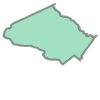

In [25]:
# Getting the boundaries for Montgomery County
moco=Polygon(boundaries['features'][17]['geometry']['rings'][0])
moco

In [26]:
# Creating a flag to determine which coordinates are in the county boundaries
def county_flag(row):
    point = Point(row['pol_lon'], row['pol_lat'])
    return moco.contains(point)

df['in_MOCO'] = df.apply(county_flag, axis=1)

In [27]:
#Rounding milepoint for easy matching with Miles Points data
df['milepoint'] = df['milepoint'].round(decimals=3)
df.head()

,reportnumber,localcasenumber,acrsreporttype,agencyname,atfault,collisiontype,crashdatetime,non_motorist_involved,non_motorist_involved_ksi,crash_highest_injury,ksi,fatal_crash,bike_involved,bike_involved_ksi,bike_highest_injury,ped_involved,ped_involved_ksi,ped_highest_injury,motorist_highest_injury,driver_highest_injury,passenger_highest_injury,lanedirection,fixedobjectstruck,hitandrun,harmfulevent1,harmfulevent2,reportcountylocation,nontraffic,offroaddescription,integerchangearea,interchangeidentification,intersectiontype,junction,lanenumber,pol_lat,pol_lon,final_lat,final_lon,lanetype,light,milepointdirection,milepointdistance,milepointdistunits,numberoflanes,logmile_dir,milepoint,municipal,municipal_area_code,reference_muni,route_type,route_suffix,route_number,road_name,reference_route_type,reference_route_suffix,reference_route_number,reference_roadname,roadalignment,roadcondition,roaddivision,roadgrade,ramp,surfacecondition,trafficcontrol,weather,agency,agency_clean,year,month,day,milepointdistanceinfeet,polcoorddist,polfinalflag,road_name_clean,new_light,new_surface,new_weather,in_MOCO
0,MCP11520005,15000008,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 00:30:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,Y,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION RELATED,NaN,FOUR-WAY INTERSECTION,INTERSECTION RELATED,1.0,39.022001,-77.102673,39.022465,-77.102737,NaN,DARK LIGHTS ON,N,0.0,FEET,3.0,N,4.38,NaN,NaN,NaN,MD,NaN,355.0,ROCKVILLE PIKE,CO,NaN,326.0,GROSVENOR LA,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0,169.871714,Correct,ROCKVILLE PIKE,Dark,DRY,CLEAR,True
1,MCP2686000D,15000017,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 01:10:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,S,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,ON RAMP EXIT AREA,NaN,T-INTERSECTION,INTERCHANGE RELATED,NaN,39.196610,-77.265547,39.196526,-77.265297,ON RAMP,DARK LIGHTS ON,S,10.0,FEET,1.0,S,0.15,NaN,NaN,NaN,RP,NaN,270.0,RAMP 5 FR RAMP 8 TO FATHER HURLEY BLVD,CO,NaN,4556.0,FATHER HURLEY BLVD,CURVE LEFT,NO DEFECTS,ONE-WAY TRAFFICWAY,HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,NaN,MCP,Montgomery County Police,2015,1,1,10.0,77.170480,Correct,RAMP 5 FR RAMP 8 TO FATHER HURLEY BLVD,Dark,DRY,NaN,True
2,MCP2783000G,15000025,Injury Crash,Montgomery County Police,DRIVER,HEAD ON,2015-01-01 01:14:00,MOTORIST,MOTORIST,3,False,False,False,False,0,False,False,0,3,3,0,E,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,NaN,NaN,FOUR-WAY INTERSECTION,INTERSECTION,2.0,39.096217,-77.109803,39.096077,-77.109871,NaN,DARK LIGHTS ON,E,0.0,FEET,3.0,E,25.21,NaN,NaN,NaN,MD,NaN,28.0,NORBECK RD,CO,NaN,3377.0,BAUER DR,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0,54.378056,Correct,NORBECK RD,Dark,DRY,CLEAR,True
3,MCP2674000D,15000016,Property Damage Crash,Montgomery County Police,DRIVER,OPPOSITE DIR BOTH LEFT TURN,2015-01-01 01:26:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,W,NaN,N,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION,NaN,FOUR-WAY INTERSECTION,INTERSECTION,NaN,39.158059,-77.204349,39.158020,-77.204430,LEFT TURN LANE,DARK LIGHTS ON,N,0.0,FEET,2.0,N,0.76,NaN,NaN,NaN,CO,NaN,4863.0,CHRISTOPHER AVE,MD,NaN,124.0,MONTGOMERY VILLAGE AVE,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0,26.914074,Correct,CHRISTOPHER AVE,Dark,DRY,CLEAR,True
4,MCP23000002,15000197,Property Damage Crash,Montgomery County Police,UNKNOWN,SINGLE VEHICLE,2015-01-01 02:00:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,N,OTHER,NaN,Montgomery,NO,NaN,NaN,NaN,NaN,NON INTERSECTION,1.0,39.148678,-77.093848,39.148697,-77.093819,NaN,DARK NO LIGHTS,N

In [28]:
hundredth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593747 entries, 0 to 593746
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   X                   593747 non-null  float64
 1   Y                   593747 non-null  float64
 2   OBJECTID            593747 non-null  int64  
 3   ID_MP               593747 non-null  float64
 4   COUNTY              593747 non-null  int64  
 5   ROAD_NAME           484934 non-null  object 
 6   ID_PREFIX           593747 non-null  object 
 7   ID_RTE_NO           593747 non-null  int64  
 8   MP_SUFFIX           4352 non-null    object 
 9   MP_DIRECTION        528061 non-null  object 
 10  CAL_DIRECTION       528061 non-null  object 
 11  CARDINALITY         593747 non-null  int64  
 12  MAIN_LINE           528061 non-null  float64
 13  EXIT_NUMBER         7620 non-null    object 
 14  RAMP_NUMBER         7620 non-null    float64
 15  ASSOC_ID_PREFIX     7620 non-null 

In [29]:
hundredth.head()

,X,Y,OBJECTID,ID_MP,COUNTY,ROAD_NAME,ID_PREFIX,ID_RTE_NO,MP_SUFFIX,MP_DIRECTION,CAL_DIRECTION,CARDINALITY,MAIN_LINE,EXIT_NUMBER,RAMP_NUMBER,ASSOC_ID_PREFIX,ROUTE_ID,MUN_SORT,IS_INTERSECTION,X_COORD,Y_COORD,LONGITUDE,LATITUDE,GLOBAL_SEGMENT_ID,SUB_ROUTE_ID,GLOBAL_ROUTE_ID,STATE_MP,STMP_SEQ,AT_ROUTE_ROAD_NAME,AT_ROUTE_ID,AGOL_POPUP,ROUTEID,DISTRICT,MAINT_SHOP,MAINT_SHOP_DESC,GOVT_CONTROL,GOVT_CONTROL_DESC
0,-77.232780,39.311731,6874821,1.90,15,MOXLEY RD,CO,1,NaN,S,S,1,1.0,NaN,NaN,NaN,15000CO00001--1-----,0,0,1.246469e+06,599206.055448,-77.232780,39.311731,NaN,NaN,NaN,-1,-1,NaN,NaN,CO-1,15000CO00001 01SS**************,3,0.0,NaN,2.0,County Highway Agency
1,-77.232780,39.311731,6874822,1.90,15,MOXLEY RD,CO,1,NaN,S,S,1,1.0,NaN,NaN,NaN,15000CO00001--1-----,0,0,1.246469e+06,599206.055448,-77.232780,39.311731,NaN,NaN,NaN,-1,-1,NaN,NaN,CO-1,15000CO00001 01SS**************,3,0.0,NaN,2.0,County Highway Agency
2,-77.232947,39.311670,6874823,1.91,15,MOXLEY RD,CO,1,NaN,S,S,1,1.0,NaN,NaN,NaN,15000CO00001--1-----,0,0,1.246421e+06,599184.023012,-77.232947,39.311670,NaN,NaN,NaN,-1,-1,NaN,NaN,CO-1,15000CO00001 01SS**************,3,0.0,NaN,2.0,County Highway Agency
3,-77.233117,39.311614,6874824,1.92,15,MOXLEY RD,CO,1,NaN,S,S,1,1.0,NaN,NaN,NaN,15000CO00001--1-----,0,0,1.246373e+06,599163.672331,-77.233117,39.311614,NaN,NaN,NaN,-1,-1,NaN,NaN,CO-1,15000CO00001 01SS**************,3,0.0,NaN,2.0,County Highway Agency
4,-77.233288,39.311559,6874825,1.93,15,MOXLEY RD,CO,1,NaN,S,S,1,1.0,NaN,NaN,NaN,15000CO00001--1-----,0,0,1.246324e+06,599143.784576,-77.233288,39.311559,NaN,NaN,NaN,-1,-1,NaN,NaN,CO-1,15000CO00001 01SS**************,3,0.0,NaN,2.0,County Highway Agency


In [30]:
hundredth['COUNTY'] = hundredth['COUNTY'].replace(to_replace=15, value='Montgomery')
hundredth=hundredth[['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'MP_SUFFIX','ID_RTE_NO','ROAD_NAME', 'LATITUDE', 'LONGITUDE']] #removing nonrelevant columns
dfmp = pd.merge(df,hundredth, how='left',left_on=['milepoint','logmile_dir', 'reportcountylocation', 'route_type', 'route_suffix', 'route_number','road_name_clean'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'MP_SUFFIX', 'ID_RTE_NO','ROAD_NAME'])
dfmp

,reportnumber,localcasenumber,acrsreporttype,agencyname,atfault,collisiontype,crashdatetime,non_motorist_involved,non_motorist_involved_ksi,crash_highest_injury,ksi,fatal_crash,bike_involved,bike_involved_ksi,bike_highest_injury,ped_involved,ped_involved_ksi,ped_highest_injury,motorist_highest_injury,driver_highest_injury,passenger_highest_injury,lanedirection,fixedobjectstruck,hitandrun,harmfulevent1,harmfulevent2,reportcountylocation,nontraffic,offroaddescription,integerchangearea,interchangeidentification,intersectiontype,junction,lanenumber,pol_lat,pol_lon,final_lat,final_lon,lanetype,light,milepointdirection,milepointdistance,milepointdistunits,numberoflanes,logmile_dir,milepoint,municipal,municipal_area_code,reference_muni,route_type,route_suffix,route_number,road_name,reference_route_type,reference_route_suffix,reference_route_number,reference_roadname,roadalignment,roadcondition,roaddivision,roadgrade,ramp,surfacecondition,trafficcontrol,weather,agency,agency_clean,year,month,day,milepointdistanceinfeet,polcoorddist,polfinalflag,road_name_clean,new_light,new_surface,new_weather,in_MOCO,ID_MP,MP_DIRECTION,COUNTY,ID_PREFIX,MP_SUFFIX,ID_RTE_NO,ROAD_NAME,LATITUDE,LONGITUDE
0,MCP11520005,15000008,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 00:30:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,N,NaN,Y,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION RELATED,NaN,FOUR-WAY INTERSECTION,INTERSECTION RELATED,1.0,39.022001,-77.102673,39.022465,-77.102737,NaN,DARK LIGHTS ON,N,0.0,FEET,3.0,N,4.38,NaN,NaN,NaN,MD,NaN,355.0,ROCKVILLE PIKE,CO,NaN,326.0,GROSVENOR LA,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0,169.871714,Correct,ROCKVILLE PIKE,Dark,DRY,CLEAR,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MCP2686000D,15000017,Property Damage Crash,Montgomery County Police,DRIVER,SAME DIR REAR END,2015-01-01 01:10:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,S,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,ON RAMP EXIT AREA,NaN,T-INTERSECTION,INTERCHANGE RELATED,NaN,39.196610,-77.265547,39.196526,-77.265297,ON RAMP,DARK LIGHTS ON,S,10.0,FEET,1.0,S,0.15,NaN,NaN,NaN,RP,NaN,270.0,RAMP 5 FR RAMP 8 TO FATHER HURLEY BLVD,CO,NaN,4556.0,FATHER HURLEY BLVD,CURVE LEFT,NO DEFECTS,ONE-WAY TRAFFICWAY,HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,NaN,MCP,Montgomery County Police,2015,1,1,10.0,77.170480,Correct,RAMP 5 FR RAMP 8 TO FATHER HURLEY BLVD,Dark,DRY,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MCP2783000G,15000025,Injury Crash,Montgomery County Police,DRIVER,HEAD ON,2015-01-01 01:14:00,MOTORIST,MOTORIST,3,False,False,False,False,0,False,False,0,3,3,0,E,NaN,N,OTHER VEHICLE,OTHER VEHICLE,Montgomery,NO,NaN,NaN,NaN,FOUR-WAY INTERSECTION,INTERSECTION,2.0,39.096217,-77.109803,39.096077,-77.109871,NaN,DARK LIGHTS ON,E,0.0,FEET,3.0,E,25.21,NaN,NaN,NaN,MD,NaN,28.0,NORBECK RD,CO,NaN,3377.0,BAUER DR,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",LEVEL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0,54.378056,Correct,NORBECK RD,Dark,DRY,CLEAR,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MCP2674000D,15000016,Property Damage Crash,Montgomery County Police,DRIVER,OPPOSITE DIR BOTH LEFT TURN,2015-01-01 01:26:00,MOTORIST,MOTORIST,1,False,False,False,False,0,False,False,0,1,1,0,W,NaN,N,OTHER VEHICLE,NaN,Montgomery,NO,NaN,INTERSECTION,NaN,FOUR-WAY INTERSECTION,INTERSECTION,NaN,39.158059,-77.204349,39.158020,-77.204430,LEFT TURN LANE,DARK LIGHTS ON,N,0.0,FEET,2.0,N,0.76,NaN,NaN,NaN,CO,NaN,4863.0,CHRISTOPHER AVE,MD,NaN,124.0,MONTGOMERY VILLAGE AVE,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",HILL UPHILL,NaN,DRY,TRAFFIC SIGNAL,CLEAR,MCP,Montgomery County Police,2015,1,1,0.0,26.914074,Correct,CHRISTOPHER AVE,Dark,DRY,CLEAR,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MCP23000002,15000197,Property Damage Crash,Montgomery County Police,UNKNOWN,SIN

In [31]:
# Checking for null values
dfmp.isnull().sum()

reportnumber           0
localcasenumber        0
acrsreporttype         0
agencyname             0
atfault                0
                   ...  
MP_SUFFIX          83964
ID_RTE_NO          72673
ROAD_NAME          72673
LATITUDE           72673
LONGITUDE          72673
Length: 87, dtype: int64

In [32]:
dfmp.duplicated().sum()

606

In [33]:
# Removing duplicates and confirming they were dropped
dfmp=dfmp.drop_duplicates(subset=['reportnumber'], keep="first")
dfmp.duplicated().sum()

0

In [34]:
unmatched = dfmp.loc[dfmp['LATITUDE'].isin([np.NaN, None])]

In [35]:
unmatched = unmatched.drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE'])

In [36]:
unmatched['milepoint'] = unmatched['milepoint'].apply(lambda x: '{:.3f}'.format(x))
hundredth['ID_MP'] = hundredth['ID_MP'].apply(lambda x: '{:.3f}'.format(x))

In [37]:
unmatchedmp = pd.merge(unmatched,hundredth, how='left',left_on=['milepoint','logmile_dir', 'reportcountylocation', 'route_type', 'route_suffix', 'route_number','road_name_clean'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'MP_SUFFIX', 'ID_RTE_NO','ROAD_NAME'])

In [38]:
unmatchedmp.isnull().sum()

reportnumber           0
localcasenumber        0
acrsreporttype         0
agencyname             0
atfault                0
                   ...  
MP_SUFFIX          73327
ID_RTE_NO           4738
ROAD_NAME           4738
LATITUDE            4738
LONGITUDE           4738
Length: 87, dtype: int64

In [39]:
unmatchedmp.duplicated().sum()

859

In [40]:
unmatchedmp=unmatchedmp.drop_duplicates(subset=['reportnumber'], keep="first")
unmatchedmp.duplicated().sum()

0

In [41]:
unmatched2 = unmatchedmp.loc[unmatchedmp['LATITUDE'].isin([np.NaN, None])]

In [42]:
unmatched2 = unmatched2.drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE'])

In [43]:
unmatched2['milepoint']=unmatched2['milepoint'].astype('float64')
hundredth['ID_MP']=hundredth['ID_MP'].astype('float64')
unmatched2['milepoint'] = unmatched2['milepoint'].apply(lambda x: '{:.2f}'.format(x))
hundredth['ID_MP'] = hundredth['ID_MP'].apply(lambda x: '{:.2f}'.format(x))
unmatchedmp2 = pd.merge(unmatched2,hundredth, how='left',left_on=['milepoint','logmile_dir', 'reportcountylocation', 'route_type', 'route_suffix', 'route_number','road_name_clean'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'MP_SUFFIX', 'ID_RTE_NO','ROAD_NAME'])

In [44]:
unmatchedmp2.duplicated().sum()

155

In [45]:
unmatchedmp2=unmatchedmp2.drop_duplicates(subset=['reportnumber'], keep="first")
unmatchedmp2.duplicated().sum()

0

In [46]:
unmatched2 = unmatchedmp2.drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE'])

In [49]:
unmatched3 = unmatchedmp2.loc[unmatchedmp2['LATITUDE'].isin([np.NaN, None])]

In [50]:
unmatched3 = unmatched3.drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE'])

In [51]:
unmatched3['milepoint']=unmatched3['milepoint'].astype('float64')
hundredth['ID_MP']=hundredth['ID_MP'].astype('float64')
unmatched3['milepoint'] = unmatched3['milepoint'].apply(lambda x: '{:.1f}'.format(x))
hundredth['ID_MP'] = hundredth['ID_MP'].apply(lambda x: '{:.1f}'.format(x))
unmatchedmp3 = pd.merge(unmatched3,hundredth, how='left',left_on=['milepoint','logmile_dir', 'reportcountylocation', 'route_type', 'route_suffix', 'route_number','road_name_clean'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'MP_SUFFIX', 'ID_RTE_NO','ROAD_NAME'])
unmatchedmp3.isnull().sum()

reportnumber          0
localcasenumber       0
acrsreporttype        0
agencyname            0
atfault               0
                   ... 
MP_SUFFIX          6630
ID_RTE_NO          2033
ROAD_NAME          2033
LATITUDE           2033
LONGITUDE          2033
Length: 87, dtype: int64

In [52]:
unmatchedmp3.duplicated().sum()

403

In [53]:
unmatchedmp3=unmatchedmp3.drop_duplicates(subset=['reportnumber'], keep="first")
unmatchedmp3.duplicated().sum()

0

In [54]:
matched4 =unmatchedmp3[~unmatchedmp3['LATITUDE'].isna()]
unmatched4 = unmatchedmp3.loc[unmatchedmp3['LATITUDE'].isin([np.NaN, None])]

In [55]:
unmatched4 = unmatched4.drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE'])

In [56]:
unmatched4['milepoint']=unmatched4['milepoint'].astype('float64')
hundredth['ID_MP']=hundredth['ID_MP'].astype('float64')
unmatched4['milepoint'] = unmatched4['milepoint'].apply(lambda x: '{:.1f}'.format(x))
hundredth['ID_MP'] = hundredth['ID_MP'].apply(lambda x: '{:.1f}'.format(x))
unmatchedmp4 = pd.merge(unmatched4,hundredth, how='left',left_on=['milepoint','logmile_dir','reportcountylocation','road_name_clean'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY','ROAD_NAME'])
unmatchedmp4.isnull().sum()

reportnumber           0
localcasenumber        0
acrsreporttype         0
agencyname             0
atfault                0
                   ...  
MP_SUFFIX          10261
ID_RTE_NO           1115
ROAD_NAME           1115
LATITUDE            1115
LONGITUDE           1115
Length: 87, dtype: int64

In [57]:
unmatchedmp4.duplicated().sum()

686

In [58]:
unmatchedmp4=unmatchedmp4.drop_duplicates(subset=['reportnumber'], keep="first")
unmatchedmp4.duplicated().sum()

0

In [59]:
unmatchedmp4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2033 entries, 0 to 12037
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   reportnumber               2033 non-null   object        
 1   localcasenumber            2033 non-null   object        
 2   acrsreporttype             2033 non-null   object        
 3   agencyname                 2033 non-null   object        
 4   atfault                    2033 non-null   object        
 5   collisiontype              2019 non-null   object        
 6   crashdatetime              2033 non-null   datetime64[ns]
 7   non_motorist_involved      2033 non-null   object        
 8   non_motorist_involved_ksi  2033 non-null   object        
 9   crash_highest_injury       2033 non-null   int64         
 10  ksi                        2033 non-null   bool          
 11  fatal_crash                2033 non-null   bool          
 12  bike_invol

In [60]:
matched5 =unmatchedmp4[~unmatchedmp4['LATITUDE'].isna()]
unmatched5 = unmatchedmp4.loc[unmatchedmp4['LATITUDE'].isin([np.NaN, None])]

In [61]:
final_df=dfmp.combine_first(unmatchedmp)

In [62]:
dfmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83399 entries, 0 to 84004
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   reportnumber               83399 non-null  object        
 1   localcasenumber            83399 non-null  object        
 2   acrsreporttype             83399 non-null  object        
 3   agencyname                 83399 non-null  object        
 4   atfault                    83399 non-null  object        
 5   collisiontype              83075 non-null  object        
 6   crashdatetime              83399 non-null  datetime64[ns]
 7   non_motorist_involved      83399 non-null  object        
 8   non_motorist_involved_ksi  83399 non-null  object        
 9   crash_highest_injury       83399 non-null  int64         
 10  ksi                        83399 non-null  bool          
 11  fatal_crash                83399 non-null  bool          
 12  bike_invo

In [63]:
unmatchedmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72673 entries, 0 to 73531
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   reportnumber               72673 non-null  object        
 1   localcasenumber            72673 non-null  object        
 2   acrsreporttype             72673 non-null  object        
 3   agencyname                 72673 non-null  object        
 4   atfault                    72673 non-null  object        
 5   collisiontype              72411 non-null  object        
 6   crashdatetime              72673 non-null  datetime64[ns]
 7   non_motorist_involved      72673 non-null  object        
 8   non_motorist_involved_ksi  72673 non-null  object        
 9   crash_highest_injury       72673 non-null  int64         
 10  ksi                        72673 non-null  bool          
 11  fatal_crash                72673 non-null  bool          
 12  bike_invo

In [64]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83933 entries, 0 to 84004
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   reportnumber               83933 non-null  object        
 1   localcasenumber            83933 non-null  object        
 2   acrsreporttype             83933 non-null  object        
 3   agencyname                 83933 non-null  object        
 4   atfault                    83933 non-null  object        
 5   collisiontype              83877 non-null  object        
 6   crashdatetime              83933 non-null  datetime64[ns]
 7   non_motorist_involved      83933 non-null  object        
 8   non_motorist_involved_ksi  83933 non-null  object        
 9   crash_highest_injury       83933 non-null  int64         
 10  ksi                        83933 non-null  bool          
 11  fatal_crash                83933 non-null  bool          
 12  bike_invo

In [65]:
final_df.duplicated().sum()

0

In [66]:
def dist2(row):
    coord1 = (row['pol_lat'], row['pol_lon'])
    coord2 = (row['LATITUDE'], row['LONGITUDE'])
    if pd.isna(row['LATITUDE'])& pd.isna(row['LONGITUDE']):
        return "NaN"
    else:
        return geodesic(coord1, coord2).ft
dfmp['mpcoorddist'] = dfmp.apply(dist2, axis=1).astype(float)

/var/folders/78/93pyj2mn34gd4vxp369l_tvm0000gn/T/ipykernel_16604/1572148987.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmp['mpcoorddist'] = dfmp.apply(dist2, axis=1).astype(float)


In [67]:
def coord_flag2(row):
    if row['mpcoorddist'] <=1000:
        return 'Correct'
    elif row['mpcoorddist'] > 1000:
        return 'Incorrect'
    else:
        pass
dfmp['polmpflag'] = dfmp.apply(coord_flag2, axis=1)

/var/folders/78/93pyj2mn34gd4vxp369l_tvm0000gn/T/ipykernel_16604/3207347187.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmp['polmpflag'] = dfmp.apply(coord_flag2, axis=1)


In [68]:
dfmp['polmpflag'].value_counts()

polmpflag
Correct      9070
Incorrect    1656
Name: count, dtype: int64

In [69]:
dfmp['adjustedlat']=dfmp['LATITUDE'].where(dfmp['polmpflag']=='Correct')
dfmp['adjustedlon']=dfmp['LONGITUDE'].where(dfmp['polmpflag']=='Correct')

/var/folders/78/93pyj2mn34gd4vxp369l_tvm0000gn/T/ipykernel_16604/268750145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmp['adjustedlat']=dfmp['LATITUDE'].where(dfmp['polmpflag']=='Correct')
/var/folders/78/93pyj2mn34gd4vxp369l_tvm0000gn/T/ipykernel_16604/268750145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmp['adjustedlon']=dfmp['LONGITUDE'].where(dfmp['polmpflag']=='Correct')


In [70]:
def dist3(row):
    if (dfmp.final_lat.isna() & dfmp.final_lon.isna()) | (dfmp.final_lat.isna() & dfmp.adjustedlon.isna()):
        return 
    else:
        coord1= row(['final_lat'], row['final_lon'])
        coord2 = row(['adjustedlat'], row['adjustedlat'])
        return geodesic(coord1, coord2).ft
dfmp['adjustedcoorddist'] = dfmp.apply(dist3)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Converting police longitudes and latitudes to geodataframe
gdf=gpd.GeoDataFrame(dfmp, geometry=gpd.points_from_xy(dfmp['pol_lon'], dfmp['pol_lat']))
gdf.head()

In [ ]:
# Converting final longitudes and latitudes to geodataframe
gdffinal=gpd.GeoDataFrame(dfmp, geometry=gpd.points_from_xy(dfmp['final_lon'], dfmp['final_lat']))
gdffinal.head()

In [ ]:
# Creating data frame with both police and final geometries
gdf['geometry2']= pd.Series(gdffinal['geometry'])
gdf.head()

In [ ]:
gdf.info()

In [ ]:
#Convert objects into categories
conversion_dict={k:"category" for k in gdf.select_dtypes(include=('object')).columns}

#converting the dataframe and checking the data taype
gdf=gdf.astype(conversion_dict)
gdf.info()

In [ ]:
gdf.duplicated().sum()

In [ ]:
gdf.columns.tolist()

In [ ]:
# Dropping columns that likely will not be used in data analysis. Some dropped because of high null value and others dropped because they been used to engineer other features
final_gdf=gdf.drop(['reportnumber',
 'localcasenumber',
 'agencyname',
'collisiontype',
'lanedirection',
 'fixedobjectstruck',
'reportcountylocation',
 'nontraffic',
 'offroaddescription',
 'integerchangearea',
 'interchangeidentification',
 'intersectiontype',
'lanenumber',
'lanetype',
'milepointdirection',
'milepointdistance',
 'milepointdistunits',
 'numberoflanes',
 'logmile_dir',
 'milepoint',
 'municipal',
 'municipal_area_code',
 'reference_muni',
 'route_type',
 'route_suffix',
 'route_number',
 'road_name',
 'reference_route_type',
 'reference_route_suffix',
 'reference_route_number',
 'reference_roadname',
 'roadalignment',
 'roadcondition',
 'roaddivision',
 'roadgrade',
 'ramp',
 'ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
], axis=1)

## Exploratory Data Analysis

### Checking the packaging the data

In [ ]:
print(final_gdf.shape)

The final data set to be used has 83399 observations and 39 features.

### Examining classes of each column

In [ ]:
final_gdf.info()

### Looking at the top and bottom of the data

In [ ]:
final_gdf.head()

In [ ]:
final_gdf.tail()

In [ ]:
#Summarizing numeric variables
final_gdf.describe(include=[np.number])

In [ ]:
#Summarizing categorical variables
final_gdf.describe(include=['category'])

In [ ]:
final_gdf.isnull().sum()

In [ ]:
final_gdf.nunique()

In [ ]:
fig = px.bar(final_gdf['year'].value_counts(ascending=True), 
             template='plotly_white',
            title="Crash count per year")
fig.update_layout(showlegend=False)
fig.show()

From the figure above, we can see that 2016 had the highest number of crashes. Not surprisingly, there was a drop in accidents in 2020, but we can see that the numbers have been climbing. However, this needs to be investigated further. We also need to see if there are any changes in where accidents are occurring pre and post COVID.

In [ ]:
fig = px.bar(final_gdf['month'].value_counts(ascending=True), 
             template='plotly_white',
            title="Crash count per month")
fig.update_layout(showlegend=False)
fig.show()

The highest number of accidents are in October, but further analysis is needed. 

In [ ]:
fig = px.bar(final_gdf['crash_highest_injury'].value_counts(ascending=True), 
             template='plotly_white',
            orientation='h',
            title="Crash highest injury by count")
fig.update_layout(showlegend=False)
fig.show()

This visualization shows the majority of the crashes are non-injury crashes.

In [ ]:
# Calculating percent of crashes that are incorrect
final_gdf['polfinalflag'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

From 2015 to 2022, 12% of the crash locations had to be moved because of incorrect coordinates.

## Exploratory spatial data analysis

In [ ]:
ax = gplt.webmap(final_gdf,projection=gcrs.WebMercator())
gplt.pointplot(final_gdf['geometry'], ax=ax)

In [ ]:
final_gdf['in_MOCO'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

From 2015 to 2022, 12% of the crash locations had to be moved because of incorrect coordinates.
As shown in the figure above, a few of the crash locations were marked as quite a ways out of the county boundaries This represents .3% of the crashes .

In [ ]:
ax = gplt.webmap(final_gdf,projection=gcrs.WebMercator())
gplt.pointplot(final_gdf[final_gdf['geometry2'].is_empty], ax=ax)

This figure shows the final clean locations and seems to reveal some patterns in where crashes are concentrated.

In [ ]:
incorrect= final_gdf[final_gdf['polfinalflag']=='Incorrect']
incorrect.head()
ax = gplt.webmap(incorrect,projection=gcrs.WebMercator())
gplt.pointplot(incorrect['geometry'], ax=ax)

In [ ]:
# Creating crosstab that displays counts as percentage 
pd.crosstab(final_gdf.polfinalflag, final_gdf.agency_clean, normalize='columns')

In [ ]:
chisqt = pd.crosstab(final_gdf.polfinalflag, final_gdf.agency_clean, margins=True)
print(chisqt)
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[0:3])

From the output above, p-value is less than zero and 92.5 is the statistical value. Since the p-value is so small we reject the null hypothesis and assume that there is an association between the polfinalflag and the agency.